In [2]:
import B2D
import bitsetting
import numpy as np
import random
from skimage import io,transform
from matplotlib import pyplot as plt
from xxhash import xxh32
import nbimporter
import Toollib 
import pandas as pd
import hashlib

In [3]:
import os, re
imagelist = os.listdir('image')
imagelist = [re.sub(r'.tiff', '', i) for i in imagelist]

In [4]:
imagelist

['Baboon', 'house', 'Jet', 'Lena', 'Peppers', 'Sailboat', 'Splash', 'Tiffany']

In [5]:
import hashlib

def generate_authentication_code(gvi, rmi, bmi, i, j):
    input_string = str(gvi) + str(rmi) + str(bmi) + str(i) + str(j)
    hash_object = hashlib.md5(input_string.encode())
    hash_code = hash_object.digest()
    # 將二進位制的哈希值轉換為十進位數字
    hash_int = int.from_bytes(hash_code, byteorder='big')
    return hash_int

In [6]:
def AVGI(Graph,lr=4,lb=4):
    path = 'image/'+Graph+'.tiff'
    I=io.imread(path)
    Stego = I.copy()

    p = 0
    MSE = 0
    F = 0
    N = 0
    X = 0

    for i in range(Stego.shape[0]):
        for j in range(Stego.shape[1]):
            Gray = I[i,j,0]*0.299+I[i,j,1]*0.587+I[i,j,2]*0.114
            G_round = round(Gray)
            zero_lr =np.zeros(lr)
            zero_lb =np.zeros(lb)
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],zero_lr)
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],zero_lb)
            
            ac = generate_authentication_code(G_round, Stego[i,j,0], Stego[i,j,1], i, j)    
            ac = Toollib.fold(ac,lr+lb)
            
            bin = B2D.Dec2Bin(ac,lr+lb)
            upper = bin[0:lr]
            lower = bin[lr:]
            
            k=[]
            Stego[i,j,0] = bitsetting.lsbset(Stego[i,j,0],upper)
            k.append(Stego[i,j,0])
            Stego[i,j,2] = bitsetting.lsbset(Stego[i,j,2],lower)  
            k.append(Stego[i,j,2])
            g_bar = int((Gray - 0.299*k[0] - 0.114*k[1])/0.587)
            
            if(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) < round(Gray)):
                g_bar += 1
            elif(round(0.299*k[0]+0.587*g_bar+0.114*k[1]) > round(Gray)):
                g_bar -= 1

            if(g_bar > 255 or g_bar < 0):
                p += 1
                ac_fold = Toollib.fold(ac,2)
                Stego[i,j] = Toollib.remedy(Stego[i,j,0],Stego[i,j,1],Stego[i,j,2],ac_fold)
            else:
                Stego[i,j,1] = g_bar

            # print(f"I:{I[i,j]}, S:{Stego[i,j]}, g_bar:{(Gray - 0.299*k[0] - 0.114*k[1])/0.587}, k:{k}")

            X = 0
            delta = int(Stego[i,j,2]) - int(I[i,j,2])
            X += delta**2
            MSE += delta ** 2
            delta = int(Stego[i,j,1]) - int(I[i,j,1])
            X += delta**2
            MSE += delta ** 2 
            delta = int(Stego[i,j,0]) - int(I[i,j,0])
            X += delta**2           
            MSE += delta ** 2    
            if(X > 128):
                N += 1                                    

    MSE /= (Stego.shape[0]*Stego.shape[1]*3)
    PSNR = 10 * np.log10(65025/MSE)
    print(f"PSNR:{PSNR} , F:{p} , X:{N}")

    with open("processing_data/"+Graph+".txt","w") as file:
        file.write(f"PSNR: {PSNR}\n")
        file.write(f"outliers: {p}")


    io.imshow(Stego)
    io.show()
    io.imsave('processing_image/'+Graph+'.png',Stego)

PSNR:33.00795634837869 , F:73 , X:78159


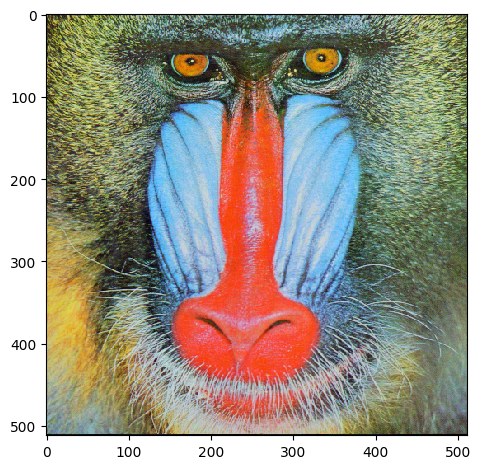

PSNR:32.85113243167234 , F:414 , X:82470


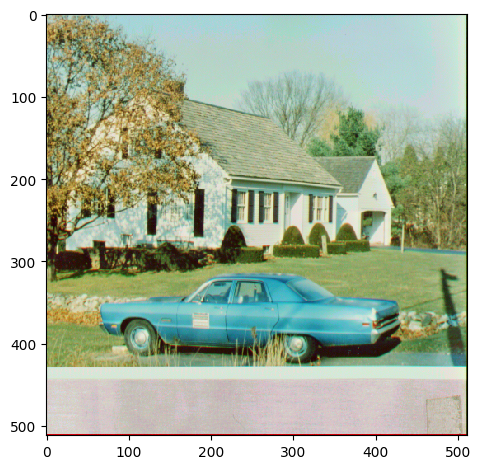

PSNR:33.00675019287578 , F:153 , X:77562


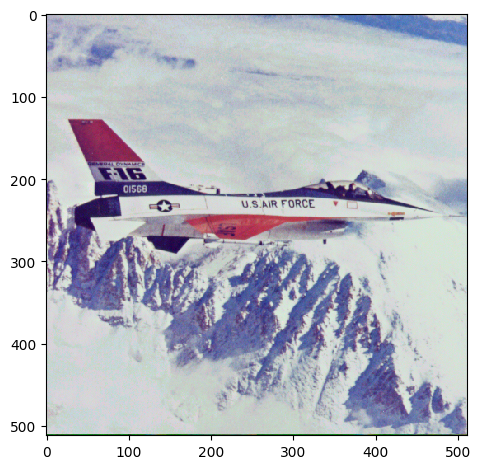

PSNR:32.91031056333205 , F:11 , X:80929


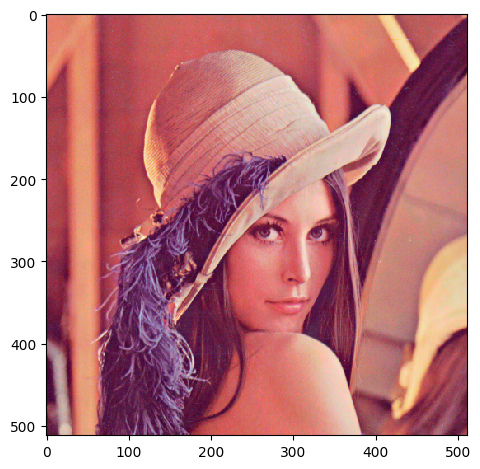

PSNR:33.001299344914514 , F:7492 , X:78567


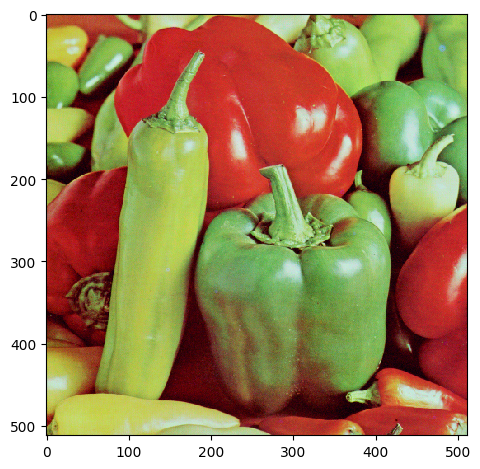

PSNR:32.995785921893834 , F:615 , X:78467


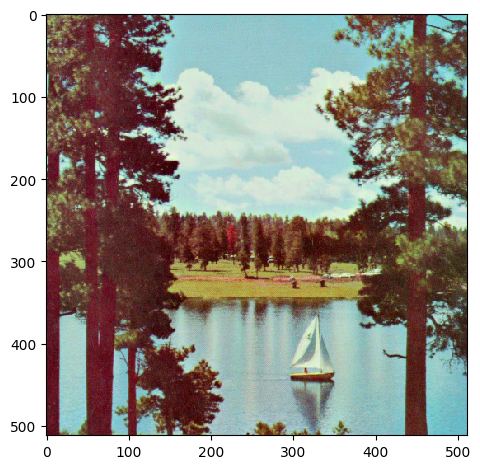

PSNR:33.03690163988549 , F:5441 , X:77815


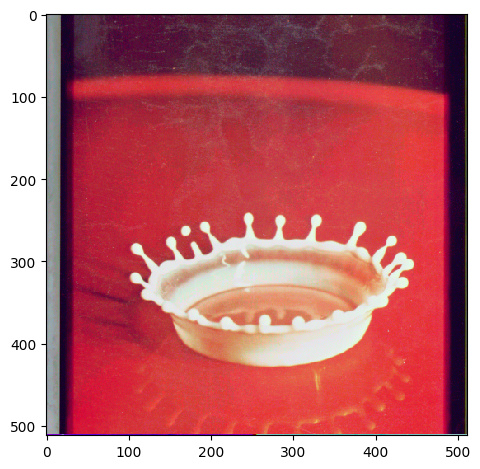

PSNR:31.712208990103072 , F:24328 , X:117876


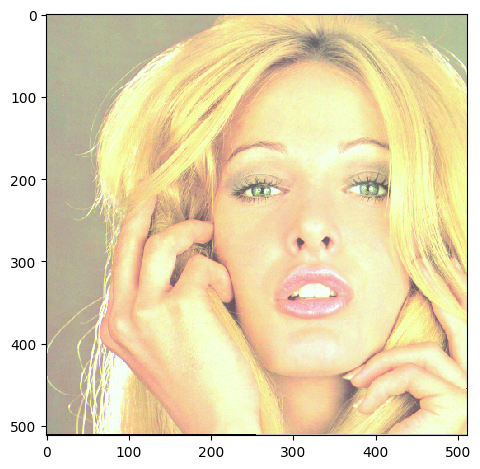

In [8]:
for image in imagelist:
    AVGI(image)